https://public.tableau.com/app/profile/david.leduc2759/viz/Milestone1gedi/Dashboard1?publish=yes
data source : https://www.kaggle.com/datasets/atharvaarya25/e-commerce-analysis-uk

# PERKENALAN

Nama : Gheddi
Batch : RMT-022

# IDENTIFIKASI MASALAH


Mengetahui tingkat penjualan bulan dalam kurun satu tahun serta melihat apakah ada korelasi antara harga dengan kuantitas pembelian

1. Negara apa diluar inggri yang paling banyak transaksinya
2. Bagaimana sebaran harga-harga produk
3. Berapa rata-rata penjualan produk per tahun
4. berapa keuntungan yang didapat tiap bulan
5. apakah ada korelasi antara harga murah dengan jumlah barang yang dibeli customer

# DATA LOADING

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats

drive.mount('/content/drive')
path = '/content/drive/MyDrive/# Hacktiv8 Data Science/ecom.csv'
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA CLEANING

Cleaning the data first before making visualization

In [2]:
# melihat apakah data seimbang
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
# menghapus baris duplikat
df = df.drop_duplicates()
# membuang baris yang berisi missing value
df.dropna(inplace= True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# ANALISIS DAN PERHITUNGAN

## Statistik Deskriptif

In [4]:
# menampilkan rata-rata, median, nilai minimum, maksimum, dan sebagainya
# dapat disimpulkan bahwa ada data yang perlu dikoreksi seperti jumlah barang yang bernilai negatif
df.describe()

Quantity      UnitPrice     CustomerID
count  401604.000000  401604.000000  401604.000000
mean       12.183273       3.474064   15281.160818
std       250.283037      69.764035    1714.006089
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13939.000000
50%         5.000000       1.950000   15145.000000
75%        12.000000       3.750000   16784.000000
max     80995.000000   38970.000000   18287.000000

In [5]:
# len(df[df['Quantity']>27]) --> 25355
len(df[df['Quantity']<=0]) # only 7182 and its faulty data so we remove them

8872

In [6]:
# menghapus baris yang jumlbah barangnya 0 dan negatif karena tidak diperlukan
index = df[(df['Quantity'] <= 0)].index
df.drop(index , inplace=True)

In [7]:
# menampilkan box plot dari unit price
# insight : kolom ini memiliki banyak outlier
fig = px.box(df, y="UnitPrice")
fig.show()

In [9]:
# dari visualisasi sebelumnya, batas atas ada di nilai 7.5
len(df[df['UnitPrice']>7.5]) #34112 / 392732 : 8%

34112

In [8]:
# menggunakan metode IQR untuk menghilangkan outlier pada kolom unit price
q1 = df['UnitPrice'].quantile(0.25)
q3 = df['UnitPrice'].quantile(0.75)
iqr = q3 - q1
outliers = df.loc[(df['UnitPrice'] < q1 - 1.5*iqr) | (df['UnitPrice'] > q3 + 1.5*iqr)]

df = df.drop(outliers.index)

## Statistik inferensial

Melihat korelasi antara harga produk yang lebih murah apakah mempengaruhi tingkat penjualan produk.

Confidence level 95%

In [9]:
# hitung median dari harga
df['UnitPrice'].median() # 1.65

1.65

In [10]:
# mengelompokkan harga berdasarkan median
# untuk mempermudah, harga murah jika dibawah atau sama dengan median
# fungsi untuk mengelompokkan harga
def grouper(row):
    if row['UnitPrice'] <= 1.65:
        val = 'CHEAP'
    else:
        val = 'EXPENSIVE'
    return val

# memanggil fungsi pada dataframe
df['Price Category'] = df.apply(grouper, axis=1)

In [11]:
# buat subset dataframe dari 2 variabel yang akan dibandingkan
CHEAP = df.query('`Price Category` =="CHEAP"')['Quantity']
EXPENSIVE = df.query('`Price Category` =="EXPENSIVE"')['Quantity']

In [13]:
# two sided test hypothesis testing
t_stat, p = stats.ttest_ind(CHEAP, EXPENSIVE)

print(f'P Value is = {p}')

P Value is = 3.357729546383821e-42


In [14]:
# metode hypothesis testing dengan one way ANOVA
fvalue, pvalue = stats.f_oneway(df.query('`Price Category` =="CHEAP"')['Quantity'],
                                df.query('`Price Category` =="EXPENSIVE"')['Quantity'])

print(f"p_value: {pvalue}")

p_value: 3.357729546256184e-42


### kesimpulan uji hipotesis

dari 2 uji hipotesis dengan metode berbeda, P value yang didapat lebih kecil dari 0.05, sehingga null hypothesis ditolak.
Jadi ada hubungan antara harga produk yang lebih murah dengan tingkat penjualan produk

## Visualisasi Data

In [24]:
fig = px.box(df, y="UnitPrice")
fig.show()
# INSIGHT : DARI BOXPLOT DIDAPATKAN BAHWWA UNIT PRICE RELATIF KECIL SEKITAR 1.65 DOLLAR DILIHAT DARI MEDIAN PADA BOXPLOT

In [25]:
# mengkonversi kolom date untuk visualisasi data lanjut
date_column = df.iloc[:,4]

#df['InvoiceDate'] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# create sales column for df index [0]
df['Sales'] = df['UnitPrice'] * df['Quantity']

df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')

In [27]:
# Display mean revenue for each month of the year
# pada tahun 2010 informasi bulan hanya 1 buah sehingga akan memakai data 2011 saja
df_2010 = df.query('Year == 2010')
df_2011 = df.query('Year == 2011')

mrev_2010 = df_2010.groupby('Month')['Sales'].sum().reset_index()
mrev_2011 = df_2011.groupby('Month')['Sales'].sum().reset_index()

<Axes: >

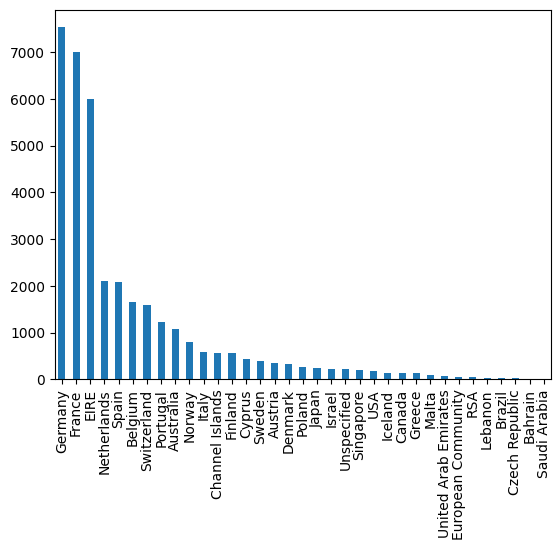

In [29]:
# Menampilkan data jumlah transaksi diluar United Kingdom karena data berasal dari UK sehingga rasio UK sangat timpang
df_2011[df_2011['Country']!='United Kingdom']['Country'].value_counts().plot(kind='bar')

# INSIGHT : DAPAT DILIHAT BAHWA TRANSAKSI PENJUALAN DILUAR UK YANG PALING BESAR ADALAH JERMAN DAN PRANCIS
# YANG MUNGKIN KARENA LETAK GEOGRAFISNYA YANG BERDEKATAN

In [32]:
# VISUALISASI KEUNTUNGAN TIAP BULAN

fig = px.line(mrev_2011, x="Month", y="Sales", text="Month")
fig.update_traces(textposition="bottom right")
fig.show()

# INSIGHT DATA PENJUALAN RELATIF MENINGKAT SEBELUM TURUN DRASTIS DI AKHIR TAHUN

In [31]:
# VISUALISASI TINGKAT BARANG TERJUAL PADA SETIAP BULAN

fig = px.pie(df_2011, values='Quantity', names='Month', title='Quantity Sold per Month')
fig.show()

# PENJULAAN MAYORITAS TINGGI PADA KUARTAL KE-3 DAN KE-4

In [26]:
from google.colab import files
df_2011.to_csv('data_clean.csv', encoding = 'utf-8-sig')
files.download('data_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PENGAMBILAN KESIMPULAN

Dari analisis yang telah dilakukan, dapat dilihat bahwa ada korelasi signifikan antara harga barang dan tingkat penjualan. Saran lanjutan adalah mengembankan pricing model yang lebih maksimal untuk meningkatkan penjualan.

In [23]:
# future todo : display composition of Customer RFM
# https://medium.com/@ugursavci/customer-segmentation-using-rfm-analysis-in-python-218a3255f714